To begin copy this notebook to your own drive:

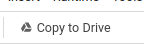


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:02<00:00, 182MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 162MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install datasets
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [5]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [6]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-7-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [9]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          input_dim = 300
          self.classifier = nn.Sequential(
              nn.Linear(input_dim, 300),
              nn.ReLU(),
              nn.Linear(300, 300),
              nn.ReLU(),
              nn.Linear(300, 300),
              nn.ReLU(),
              nn.Linear(300, 2)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      
      attention_masks = attention_masks.float()
      dropped_attention = torch.stack([nn.functional.dropout(x, p=0.0) for x in attention_masks]).long()
      dropped_words = torch.mul(self.embeddings(input_ids), dropped_attention.unsqueeze(-1))
      avg = torch.divide(torch.sum(dropped_words, dim=1), torch.count_nonzero(dropped_attention, dim=1).unsqueeze(-1))
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)

      return {"loss":loss,"logits":res}


In [10]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: tomerb5 (tomerb). Use `wandb login --relogin` to force relogin


True

In [11]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 40, #must be at least 10.
                                  per_device_train_batch_size= 32,
                                  per_device_eval_batch_size= 32,
                                  learning_rate= 0.0005,
                                  report_to="wandb",
                                  run_name="q5-DAN-layers-3-p=0-relu",
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    # callbacks = [
    #              # YOUR CODE HERE
    #              # END YOUR END
    # ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.490200,0.410774,0.813040
2,0.399400,0.499030,0.772240
3,0.400300,0.416229,0.808720
4,0.392100,0.406974,0.815320
5,0.393800,0.377268,0.834440
6,0.383700,0.382637,0.830720
7,0.373200,0.388559,0.825680
8,0.373200,0.381576,0.831040
9,0.370100,0.388689,0.825840
10,0.367700,0.390124,0.825320


TrainOutput(global_step=31280, training_loss=0.3477574763090714, metrics={'train_runtime': 1238.4961, 'train_samples_per_second': 807.431, 'train_steps_per_second': 25.256, 'total_flos': 0.0, 'train_loss': 0.3477574763090714, 'epoch': 40.0})

In [38]:
trainer.predict(small_eval_dataset)

PredictionOutput(predictions=array([[-0.7565263 ,  0.8664795 ],
       [ 0.94434077, -0.86757356],
       [ 1.2172934 , -1.1321572 ],
       ...,
       [-0.6511426 ,  0.7507464 ],
       [ 0.47754857, -0.40628314],
       [ 0.00550756,  0.07608777]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 1, 0]), metrics={'test_loss': 0.37684762477874756, 'test_accuracy': 0.84144, 'test_runtime': 12.6011, 'test_samples_per_second': 1983.955, 'test_steps_per_second': 62.058})

In [27]:
predictions = trainer.predict(small_eval_dataset)[0]

In [34]:
predict_idx = np.argmax(predictions, axis=1)

In [45]:
abs(predict_idx - small_eval_dataset["labels"])

1

'Not as bad as some people say...This is a unofficial Bond movie and a remake of "Thunderball", written by Kevin McClory (co- producer in "Thunderball"). Well, the cast is very very interesting, Maria Brandauer is a great Bond- villain, Kim Basinger and Barbara Carrera are just like the "original" Bond- girls, plus Rowan Atkinson and a truly great Edward Fox, who looks really refreshing in the "M" role. In fact, the whole movie is refreshing and gives some new impulses. Sean Connery does it once more confident and charming, except that he looks a little bit too old. But alright, he is the original Bond and it was great to see him once more in this role. The locations are also typical- Bahamas, France, etc. The only thing that really fails is the music score, the song "Never say never again" is O.K., but the theme song is just missing. All in one, a nice try to make a difference from the comic and silly Roger Moore movies like "Moonraker". Only if there was another story, "Thunderball" 